Distribution of months with data per store:
 count    268.000000
mean       5.902985
std        0.634459
min        1.000000
25%        6.000000
50%        6.000000
75%        6.000000
max        6.000000
Name: YEAR_MONTH, dtype: float64
    YEAR_MONTH  STORE_NBR  total_sales  total_customers  total_transactions  \
266    2018-08          1       176.10               42                  43   
267    2018-08          2       193.80               39                  43   
268    2018-08          3      1079.75              112                 134   
269    2018-08          4      1259.50              123                 151   
270    2018-08          5       745.10               97                 112   

     avg_transactions_per_customer  
266                       1.023810  
267                       1.102564  
268                       1.196429  
269                       1.227642  
270                       1.154639  
{77: 233, 86: 155, 88: 237}


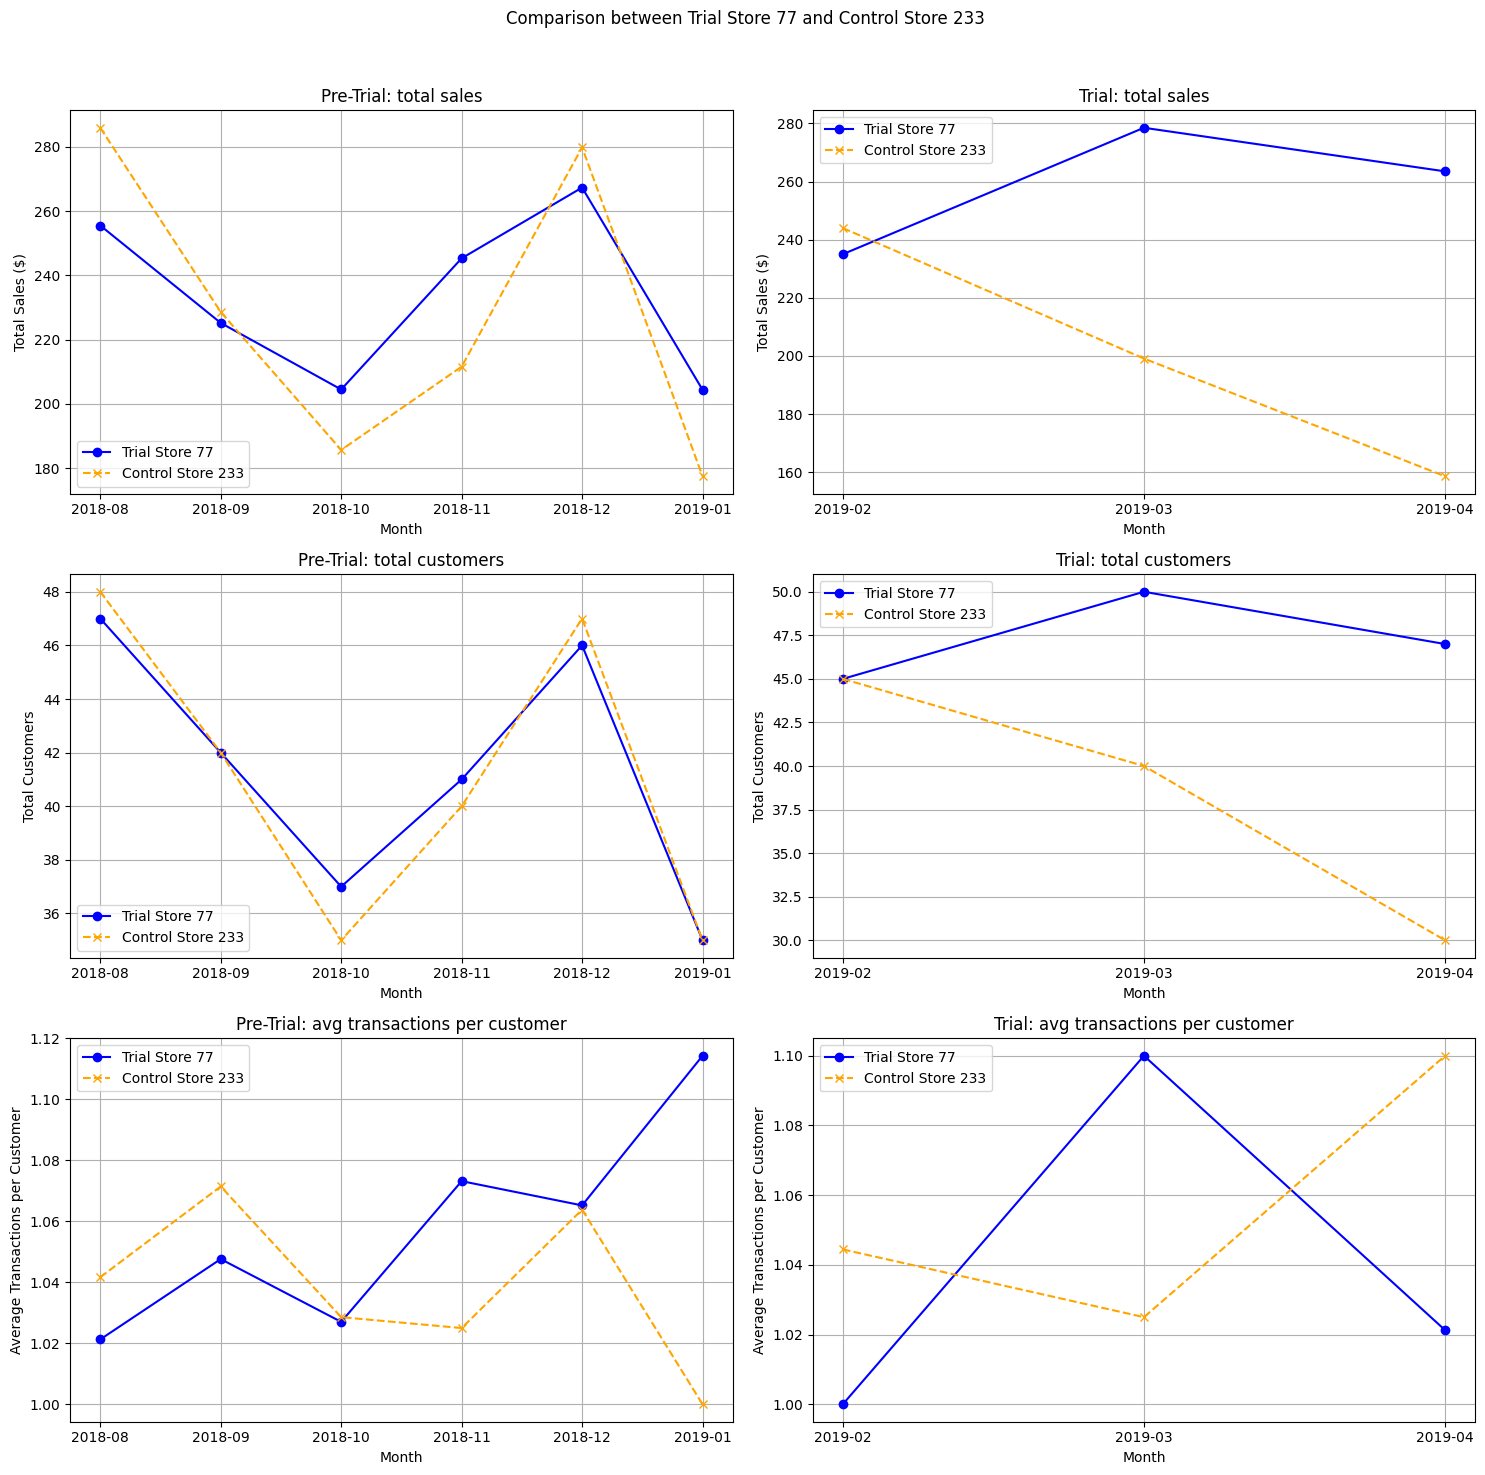

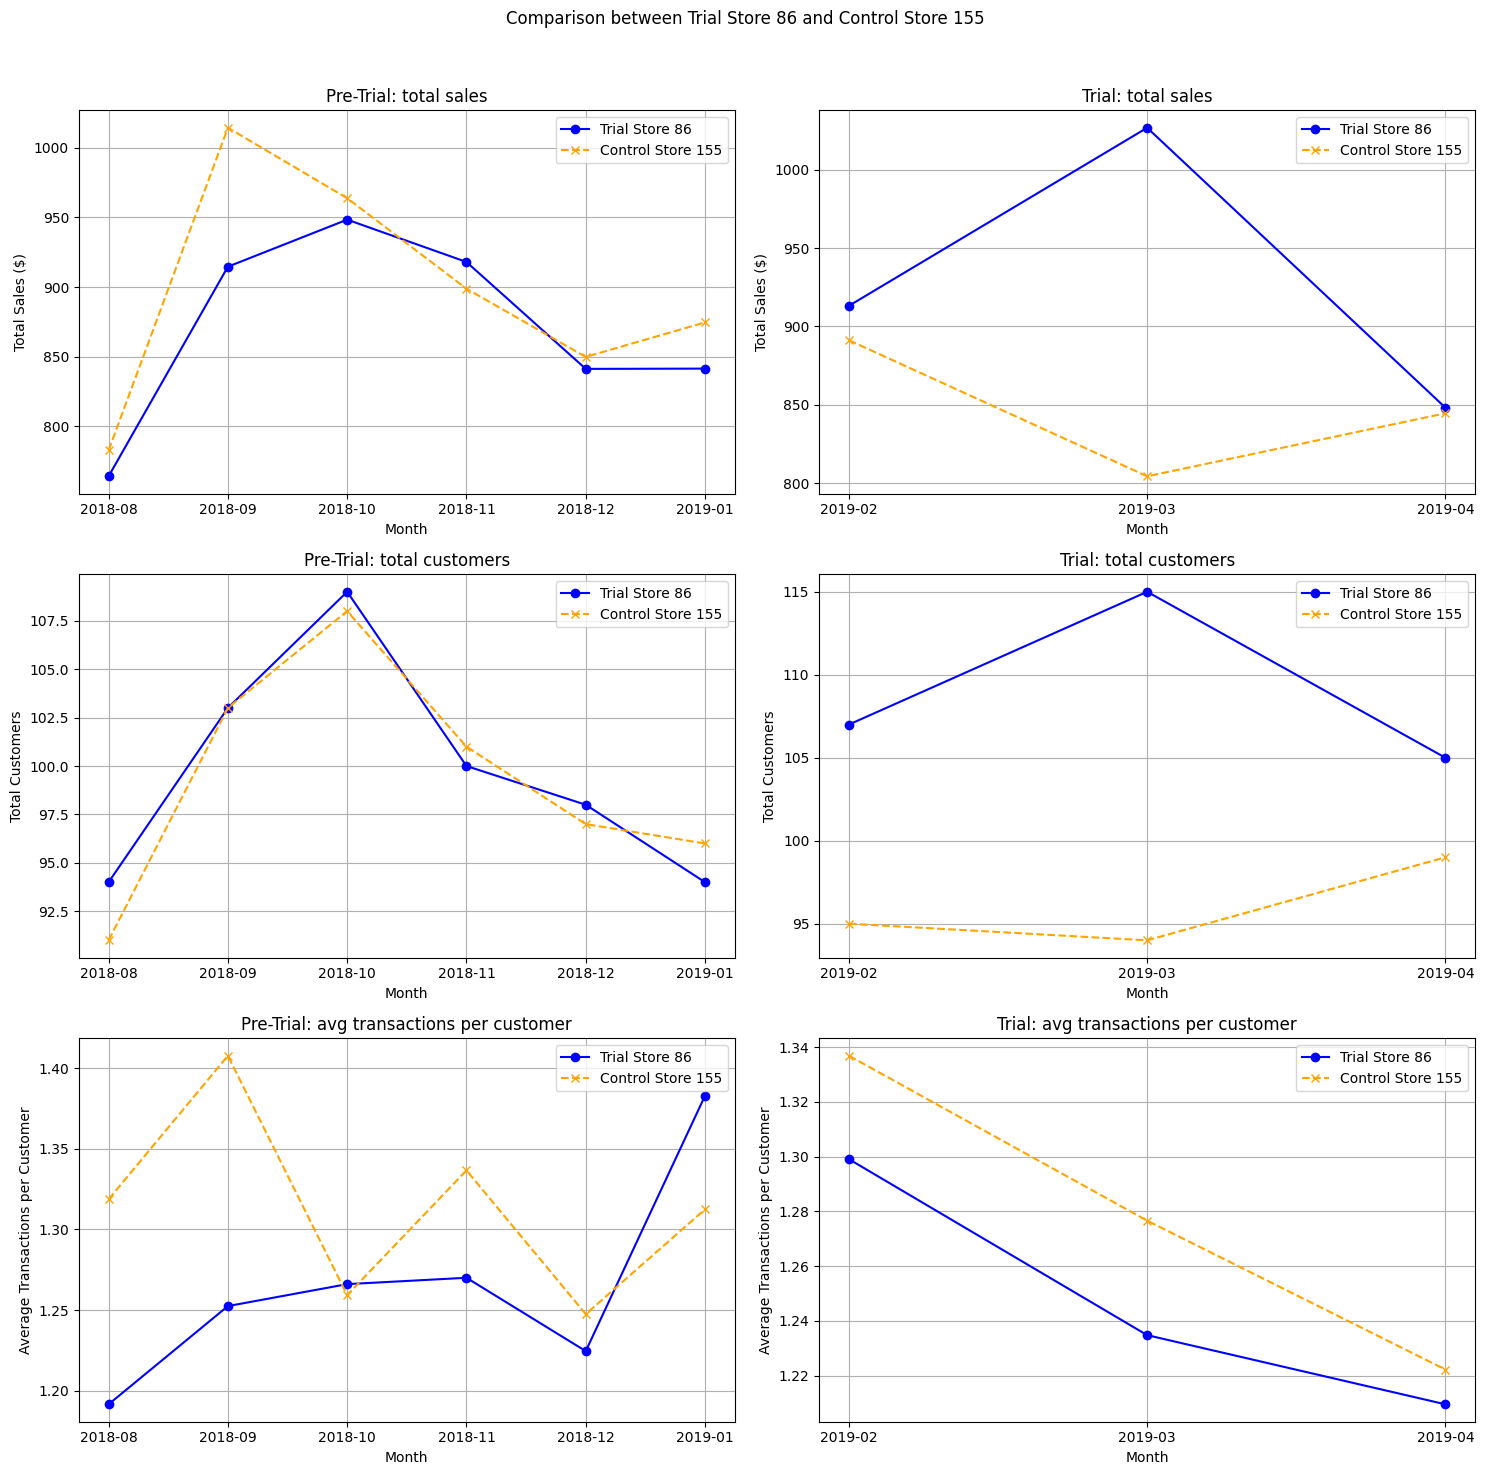

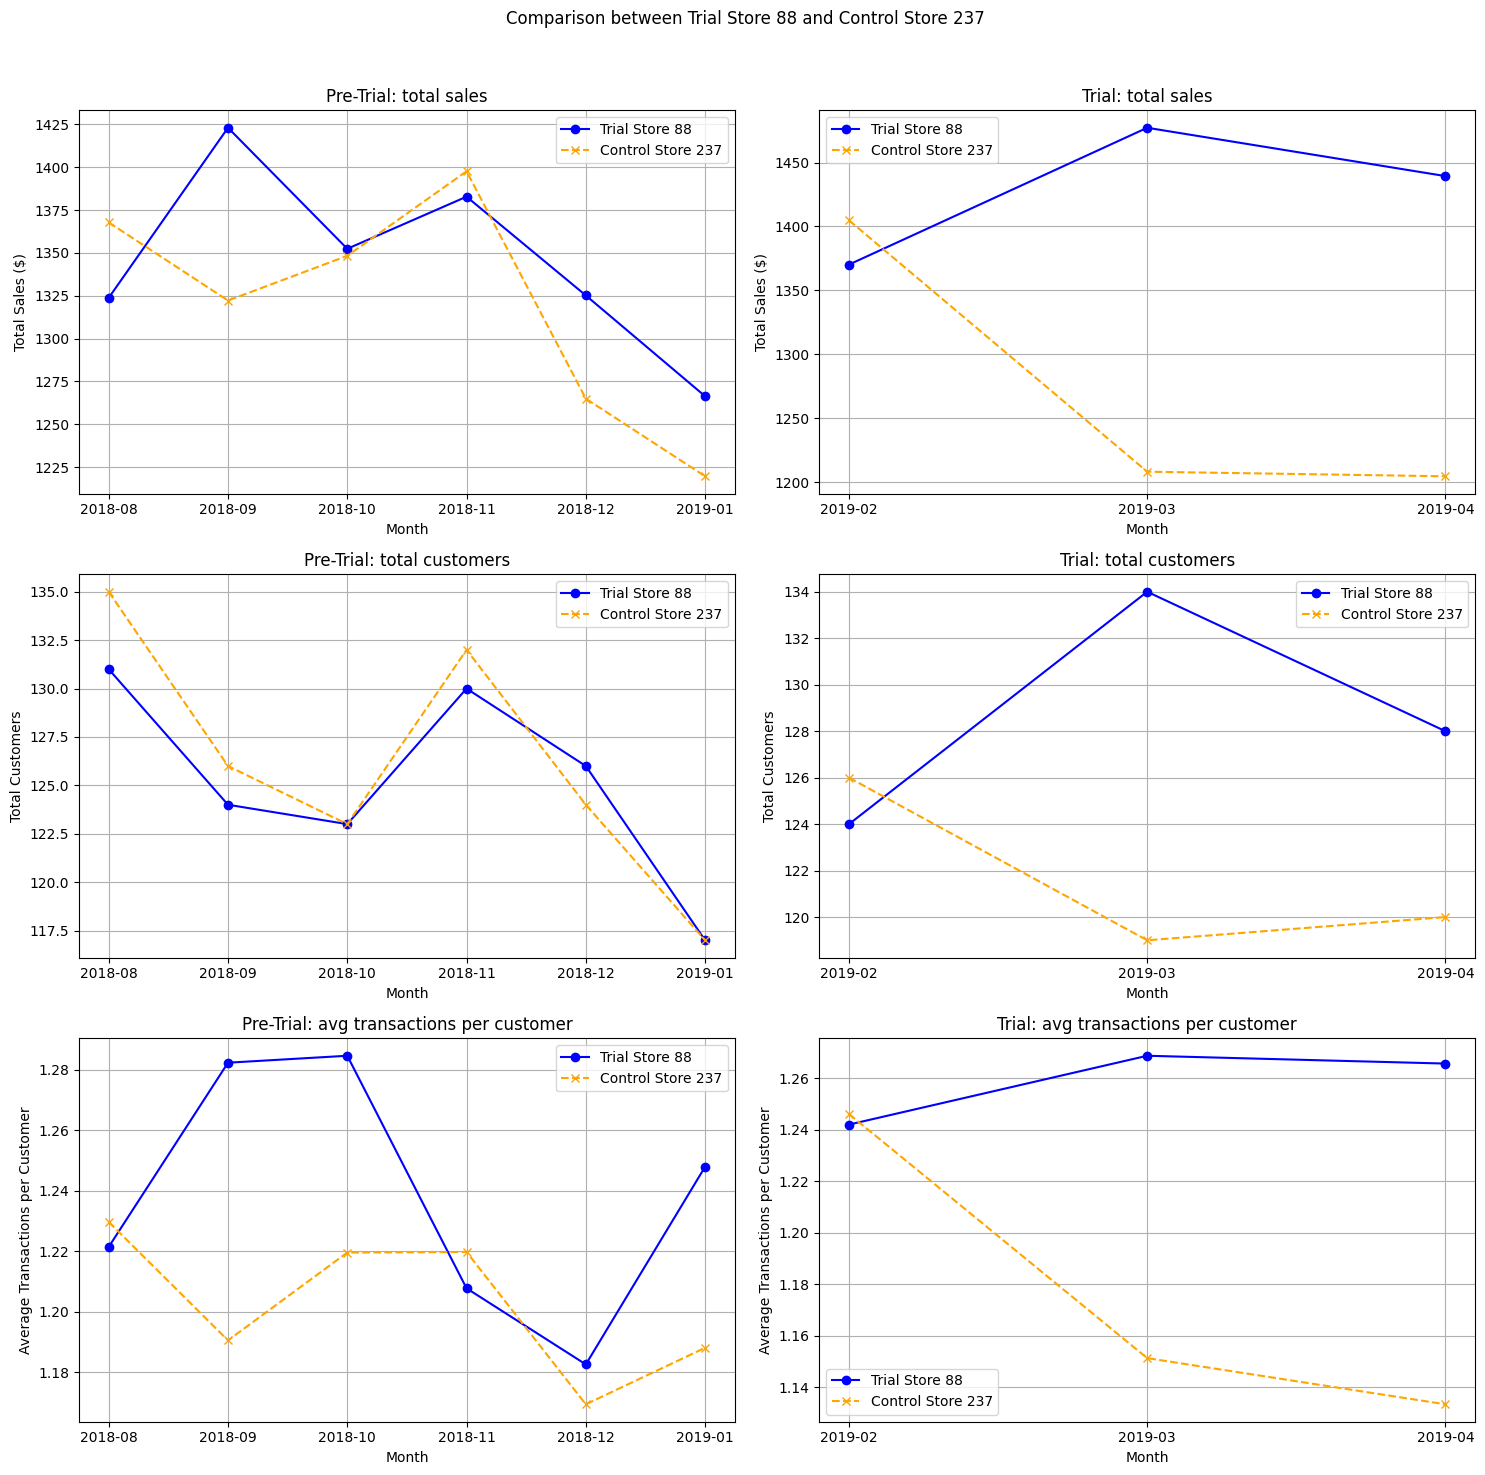

In [7]:
import pandas as pd
from scipy.spatial.distance import euclidean
from scipy.stats import zscore, pearsonr
import matplotlib.pyplot as plt
import numpy as np

# Load the dataset
file_path = 'QVI_data.csv'
data = pd.read_csv(file_path)

# Convert DATE column to datetime format
data['DATE'] = pd.to_datetime(data['DATE'])

# Extract year and month from DATE for aggregation
data['YEAR_MONTH'] = data['DATE'].dt.to_period('M')

# Aggregate data at a monthly level
monthly_data = data.groupby(['YEAR_MONTH', 'STORE_NBR']).agg({
    'TOT_SALES': 'sum',
    'LYLTY_CARD_NBR': 'nunique',
    'TXN_ID': 'count'
}).reset_index()

# Rename columns for clarity
monthly_data.rename(columns={
    'TOT_SALES': 'total_sales',
    'LYLTY_CARD_NBR': 'total_customers',
    'TXN_ID': 'total_transactions'
}, inplace=True)

# Calculate average number of transactions per customer
monthly_data['avg_transactions_per_customer'] = monthly_data['total_transactions'] / monthly_data['total_customers']

# Define the pre-trial period (use a smaller subset of the data)
pre_trial_period_start = '2018-08'
pre_trial_period_end = '2019-01'

# Filter to the pre-trial period
pre_trial_period = monthly_data[(monthly_data['YEAR_MONTH'] >= pre_trial_period_start) & 
                                (monthly_data['YEAR_MONTH'] <= pre_trial_period_end)]

# Check the number of months each store has data for in the pre-trial period
store_month_counts = pre_trial_period.groupby('STORE_NBR')['YEAR_MONTH'].nunique()
print("Distribution of months with data per store:\n", store_month_counts.describe())

# Define the minimum number of months a store should have data for to be considered
min_months_threshold = 5  
full_obs_stores = store_month_counts[store_month_counts >= min_months_threshold].index.tolist()

# Filter pre-trial period data to include only stores with data for at least min_months_threshold months
pre_trial_period = pre_trial_period[pre_trial_period['STORE_NBR'].isin(full_obs_stores)]

# Display the first few rows of the pre-trial period data
print(pre_trial_period.head())

# Define the trial period
trial_period_start = '2019-02'
trial_period_end = '2019-04'

# Filter data for the trial period
trial_period = monthly_data[(monthly_data['YEAR_MONTH'] >= trial_period_start) & 
                            (monthly_data['YEAR_MONTH'] <= trial_period_end)]

# Calculate correlation
def calculate_correlation(input_table, metric_col, store_comparison):
    correlations = []
    trial_store_data = input_table[input_table['STORE_NBR'] == store_comparison]
    
    for store in input_table['STORE_NBR'].unique():
        if store != store_comparison:
            control_store_data = input_table[input_table['STORE_NBR'] == store]
            merged_data = pd.merge(trial_store_data[['YEAR_MONTH', metric_col]],
                                   control_store_data[['YEAR_MONTH', metric_col]],
                                   on='YEAR_MONTH', suffixes=('_trial', '_control'))
            if not merged_data.empty:
                corr, _ = pearsonr(merged_data[f'{metric_col}_trial'], merged_data[f'{metric_col}_control'])
                correlations.append({'Store1': store_comparison, 'Store2': store, 'corr_measure': corr})
    
    return pd.DataFrame(correlations)

# Calculate magnitude distance
def calculate_magnitude_distance(input_table, metric_col, store_comparison):
    distances = []
    trial_store_data = input_table[input_table['STORE_NBR'] == store_comparison]
    
    for store in input_table['STORE_NBR'].unique():
        if store != store_comparison:
            control_store_data = input_table[input_table['STORE_NBR'] == store]
            merged_data = pd.merge(trial_store_data[['YEAR_MONTH', metric_col]],
                                   control_store_data[['YEAR_MONTH', metric_col]],
                                   on='YEAR_MONTH', suffixes=('_trial', '_control'))
            if not merged_data.empty:
                measure = abs(merged_data[f'{metric_col}_trial'] - merged_data[f'{metric_col}_control'])
                distances.append({'Store1': store_comparison, 'Store2': store, 'measure': measure.mean()})
    
    distance_df = pd.DataFrame(distances)
    min_dist = distance_df['measure'].min()
    max_dist = distance_df['measure'].max()
    distance_df['magnitude_measure'] = 1 - (distance_df['measure'] - min_dist) / (max_dist - min_dist)
    
    return distance_df[['Store1', 'Store2', 'magnitude_measure']]

# Combine scores
def combine_scores(corr_df, mag_df, weight=0.5):
    combined_df = pd.merge(corr_df, mag_df, on=['Store1', 'Store2'])
    combined_df['score'] = weight * combined_df['corr_measure'] + (1 - weight) * combined_df['magnitude_measure']
    return combined_df

# Function to find the best control store using the new method
def find_best_control_store_new_method(trial_store):
    corr_total_sales = calculate_correlation(pre_trial_period, 'total_sales', trial_store)
    corr_total_customers = calculate_correlation(pre_trial_period, 'total_customers', trial_store)
    magnitude_total_sales = calculate_magnitude_distance(pre_trial_period, 'total_sales', trial_store)
    magnitude_total_customers = calculate_magnitude_distance(pre_trial_period, 'total_customers', trial_store)
    
    score_total_sales = combine_scores(corr_total_sales, magnitude_total_sales)
    score_total_customers = combine_scores(corr_total_customers, magnitude_total_customers)
    
    final_scores = pd.merge(score_total_sales, score_total_customers, on=['Store1', 'Store2'])
    final_scores['final_score'] = 0.5 * final_scores['score_x'] + 0.5 * final_scores['score_y']
    
    best_control_store = final_scores.sort_values(by='final_score', ascending=False).iloc[0]['Store2']
    return int(best_control_store)

# Find best control stores for each trial store using the new method
trial_stores = [77, 86, 88]  # Ensure trial_stores is defined
new_control_stores = {trial_store: find_best_control_store_new_method(trial_store) for trial_store in trial_stores}

# Display the newly selected control stores
print(new_control_stores)

# Function to compare pre-trial and trial periods
def compare_stores_pre_and_trial(trial_store, control_store):
    metrics = {
        'total_sales': 'Total Sales ($)',
        'total_customers': 'Total Customers',
        'avg_transactions_per_customer': 'Average Transactions per Customer'
    }

    fig, axs = plt.subplots(3, 2, figsize=(15, 15))
    fig.suptitle(f'Comparison between Trial Store {trial_store} and Control Store {control_store}')
    
    for (metric, ylabel), ax in zip(metrics.items(), axs):
        # Pre-trial data
        pre_trial_data_trial = pre_trial_period[pre_trial_period['STORE_NBR'] == trial_store].set_index('YEAR_MONTH')[metric]
        pre_trial_data_control = pre_trial_period[pre_trial_period['STORE_NBR'] == control_store].set_index('YEAR_MONTH')[metric]
        pre_trial_data_trial.index = pre_trial_data_trial.index.astype(str)
        pre_trial_data_control.index = pre_trial_data_control.index.astype(str)
        
        ax[0].plot(pre_trial_data_trial.index, pre_trial_data_trial.values, label=f'Trial Store {trial_store}', marker='o', linestyle='-', color='blue')
        ax[0].plot(pre_trial_data_control.index, pre_trial_data_control.values, label=f'Control Store {control_store}', marker='x', linestyle='--', color='orange')
        ax[0].set_title(f'Pre-Trial: {metric.replace("_", " ")}')
        ax[0].set_xlabel('Month')
        ax[0].set_ylabel(ylabel)
        ax[0].legend()
        ax[0].grid(True)
        
        # Trial data
        trial_data_trial = trial_period[trial_period['STORE_NBR'] == trial_store].set_index('YEAR_MONTH')[metric]
        trial_data_control = trial_period[trial_period['STORE_NBR'] == control_store].set_index('YEAR_MONTH')[metric]
        trial_data_trial.index = trial_data_trial.index.astype(str)
        trial_data_control.index = trial_data_control.index.astype(str)
        
        ax[1].plot(trial_data_trial.index, trial_data_trial.values, label=f'Trial Store {trial_store}', marker='o', linestyle='-', color='blue')
        ax[1].plot(trial_data_control.index, trial_data_control.values, label=f'Control Store {control_store}', marker='x', linestyle='--', color='orange')
        ax[1].set_title(f'Trial: {metric.replace("_", " ")}')
        ax[1].set_xlabel('Month')
        ax[1].set_ylabel(ylabel)
        ax[1].legend()
        ax[1].grid(True)
    
    plt.tight_layout(rect=[0, 0, 1, 0.96])
    plt.show()

# Compare pre-trial and trial periods for each trial-control store pair
for trial_store, control_store in new_control_stores.items():
    compare_stores_pre_and_trial(trial_store, control_store)
